In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import statsmodels.api as sm
import numpy as np
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import graphviz
from sklearn.linear_model import Lasso, LinearRegression
import seaborn as sns

In [2]:
df_initial = pd.read_csv('datasets/edited/df_numeric.csv')

In [3]:
df_initial.columns

Index(['price', 'room_num', 'appartments', 'total_sq', 'red_line',
       'light_blue_line', 'purple_line', 'green_line', 'yellow_line',
       'light_green_line', 'dark_blue_line', 'orange_line', 'grey_line', 'mcc',
       'light_grey_line', 'light_purple_line', 'light_yellow_line',
       'sea_colour_line', 'year', 'floor', 'max_floor', 'living_space',
       'kitchen_space', 'lat', 'lon', 'distance_from_kremlin', 'subway_min',
       'min_dist_to_sub', 'NAO', 'SAO', 'UVAO', 'SZAO', 'SVAO', 'VAO', 'UAO',
       'UZAO', 'ZAO', 'ZalAO', 'CAO', 'TAO'],
      dtype='object')

## Предобработка данных:
### убираем Зеленоград, Троицк, вычищаем выбросы, убираем многокомнатные квартиры (больше 5)
### Убираем квартиры старше 2017 года

In [4]:
df = df_initial[(df_initial['ZalAO'] != 1) & (df_initial['TAO'] != 1)]

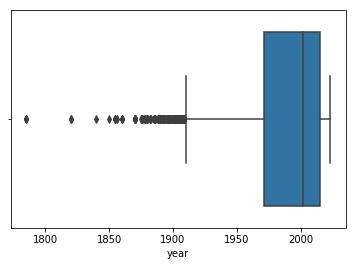

In [5]:
#Убираю 1 процент снизу у года
sns.boxplot(df['year'],whis=[1,100])

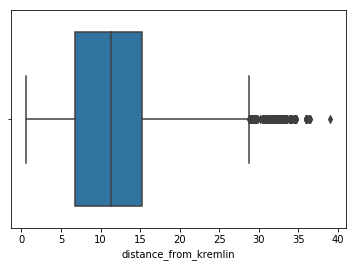

In [6]:
#Убираю 1 процент сверху у расстояния от кремля
sns.boxplot(df['distance_from_kremlin'],whis=[0,99])

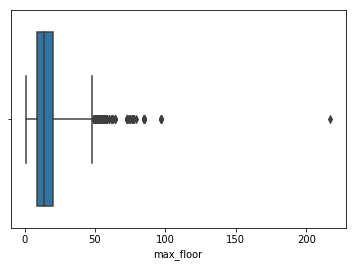

In [7]:
#Убираю 1 процент всерху у этажа, потому что тут совсем неадекватно
sns.boxplot(df['max_floor'],whis=[0,99])

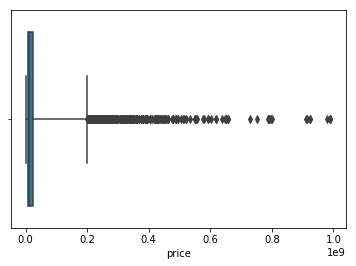

In [8]:
#Убираю 1 процент сверух у цены
sns.boxplot(df['price'],whis=[0,99])

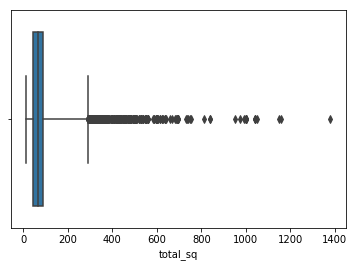

In [9]:
#Убираю один процент сверху по площади
sns.boxplot(df['total_sq'],whis=[0,99])

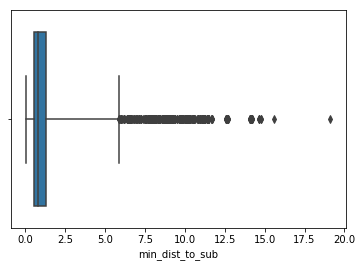

In [10]:
#Убираю один процент сверху по расстоянию до метро
sns.boxplot(df['min_dist_to_sub'],whis=[0,99])

In [11]:
df = df[(df['price'] <= df['price'].quantile(0.99))  & 
   (df['distance_from_kremlin'] <= df['distance_from_kremlin'].quantile(0.99)) &
  (df['max_floor'] <= df['max_floor'].quantile(0.99)) & (df['year'] >= df['year'].quantile(0.01)) &
  (df['total_sq'] <= df['total_sq'].quantile(0.99)) & (df['min_dist_to_sub'] <= df['min_dist_to_sub'].quantile(0.99))]

In [12]:
print('Квартир с более, чем четыремя комнатами у нас мало:',df[df['room_num'] > 4].shape[0] / df.shape[0])
print('Поэтому я их тоже выкину')
df = df[df['room_num'] <= 4]

Квартир с более, чем четыремя комнатами у нас мало: 0.029639422564343133
Поэтому я их тоже выкину


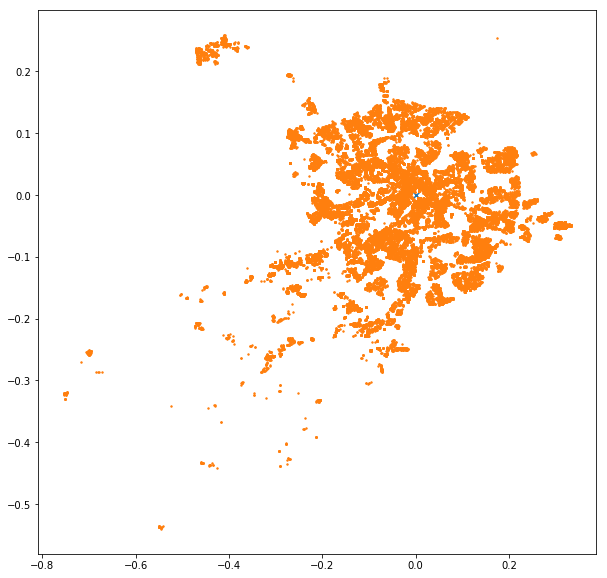

In [13]:
#Было так
plt.figure(figsize=(10,10))
plt.scatter(0, 0, marker='x')
plt.scatter(df_initial['lon'], df_initial['lat'], s=2);

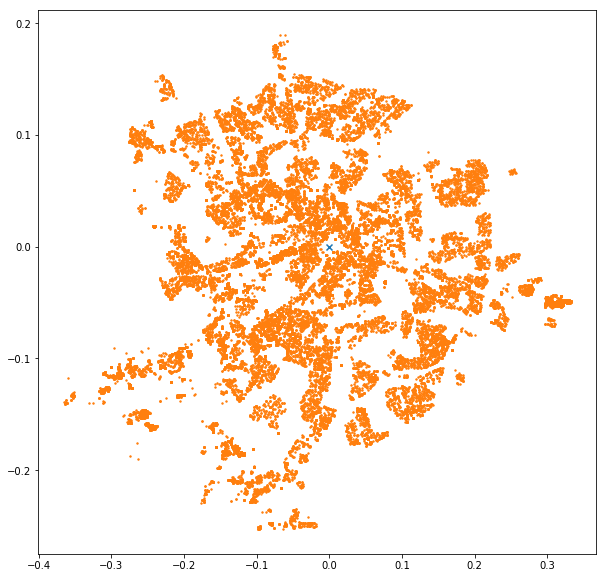

In [14]:
#А стало так
plt.figure(figsize=(10,10))
plt.scatter(0, 0, marker='x')
plt.scatter(df['lon'], df['lat'], s=2);

In [15]:
df.drop(['ZalAO','TAO'],axis=1, inplace=True)
df = df[df['year'] <= 2017]

## Описательные статистики всей базы данных

In [16]:
print('Количество объявлений:', df.shape[0])

Количество объявлений: 37216


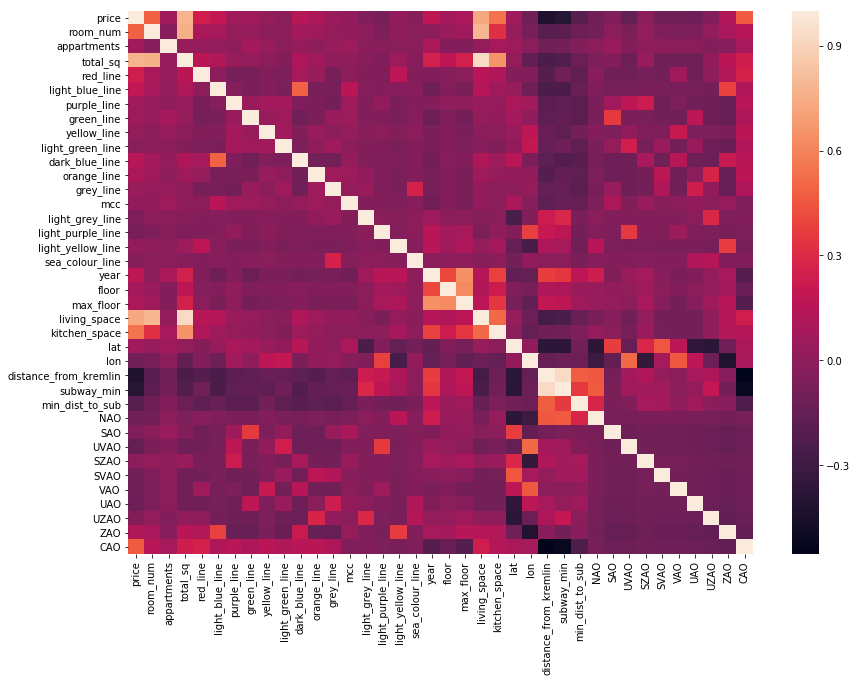

In [17]:
#heatmap всей бд
plt.figure(figsize=(14,10))
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [18]:
#Сделали признак : размер кухни ко всему размеру
df['kitchen_to_total'] = df['kitchen_space'] / df['total_sq']

In [19]:
#Сделали дамис на первый и последний этажи
df['last_floor'] = 0
df['first_floor'] = 0
ind = df[df['floor'] == df['max_floor']].index
df.loc[ind,'last_floor'] = 1
ind = df[df['floor'] == 1].index
df.loc[ind,'first_floor'] = 1

In [20]:
#cделаем дамис на количесто комнат квартиры
df['room_1'] = df['room_num'].apply(lambda x: 1 if x == 1 else 0)
df['room_2'] = df['room_num'].apply(lambda x: 1 if x == 2 else 0)
df['room_3'] = df['room_num'].apply(lambda x: 1 if x == 3 else 0)
df['room_4'] = df['room_num'].apply(lambda x: 1 if x == 4 else 0)

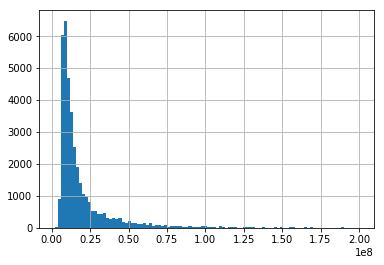

In [21]:
#Гист Цены
df['price'].hist(bins=100)

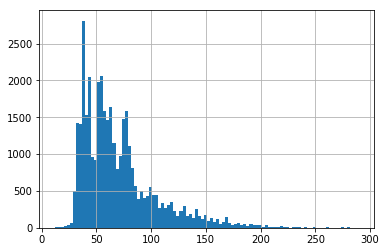

In [22]:
#Гист Цены
df['total_sq'].hist(bins=100)

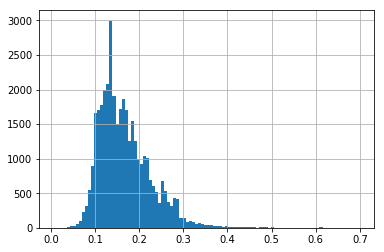

In [23]:
#Гист Размера кухни к общей площади
df['kitchen_to_total'].hist(bins=100)

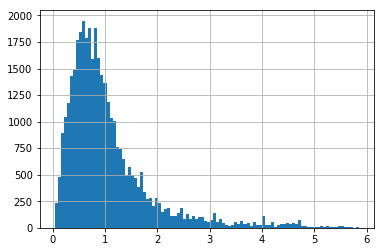

In [24]:
#Гист расстояния до метро
df['min_dist_to_sub'].hist(bins=100)

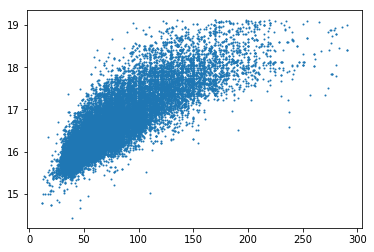

In [25]:
#Лог цена и площадь
plt.scatter(df['total_sq'], np.log(df['price']),s=1)

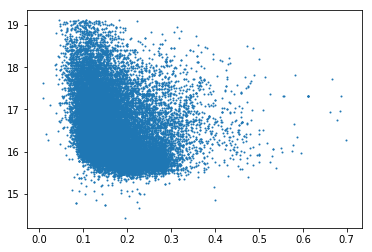

In [26]:
#Лог цена и максимальный этаж
plt.scatter(df['kitchen_to_total'], np.log(df['price']),s=1)
#вообще я бы тут приближал гипербоалми или экспонентной, но ладно оставим все линейнно

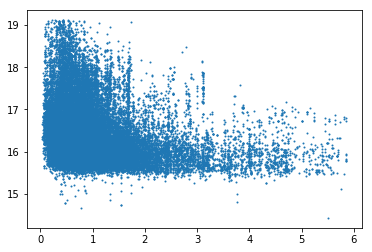

In [27]:
#Лог цена и максимальный этаж
plt.scatter(df['min_dist_to_sub'], np.log(df['price']),s=1)
#вообще я бы тут приближал гипербоалми или экспонентной, но ладно оставим все линейнно

In [28]:
#Cделаем матрицу Х и У
df = sm.add_constant(df)
X = df.drop('price', axis=1)
Y = np.log(df['price'])

In [29]:
model_1 = ['const','appartments', 'total_sq','year', 'max_floor','distance_from_kremlin', 'subway_min',
       'min_dist_to_sub','kitchen_to_total', 'last_floor', 'first_floor','room_1', 'room_2', 'room_3', 'room_4']
model_2 = model_1 + ['NAO', 'SAO', 'UVAO', 'SZAO', 'SVAO', 'VAO', 'UAO','UZAO', 'ZAO', 'CAO']
model_3 = model_2 + ['red_line','light_blue_line', 'purple_line', 'green_line', 'yellow_line','light_green_line', 
    'dark_blue_line', 'orange_line', 'grey_line', 'mcc','light_grey_line', 'light_purple_line', 'light_yellow_line',
'sea_colour_line']

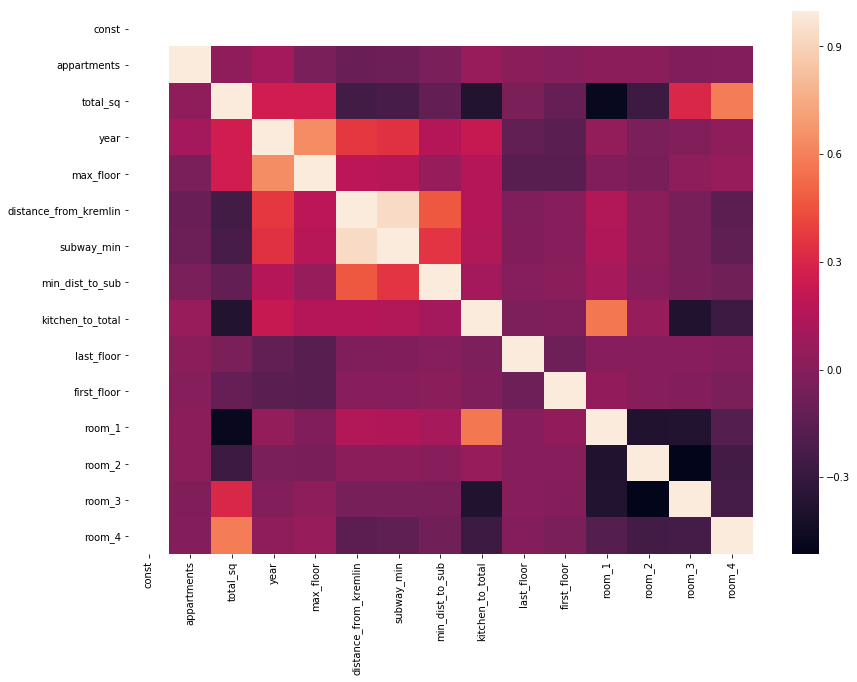

In [30]:
#Уберем тогда еще и минимальное расстояние до центра на метро, поок что сильняя корреляция 
#с растоянием до кремля
plt.figure(figsize=(14,10))
corr = df[model_1].corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## 1-ая модель: просто вещественные (без этажа), против четырехкомнатных квартир, но без расстояния до метро

In [31]:
#stats models
#Против 4ехкомнатных квартир
lr = sm.OLS(Y, X[model_1].drop(['room_4','subway_min'], axis=1)).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.865
Model:                            OLS   Adj. R-squared:                  0.865
Method:                 Least Squares   F-statistic:                 1.990e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:41:01   Log-Likelihood:                -2040.3
No. Observations:               37216   AIC:                             4107.
Df Residuals:                   37203   BIC:                             4217.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.71

## 2-ая модель: как модель 1 + районы против ЦАО

In [32]:
#stats models
#Регрессия против ЦАО и четырехкомантных квартим
#Видим, что, как и ожидалось, квартиры на западе вторые по дороговизне (после ЦАО). 
#На удивление НАО не плох, что, скорее всего, связано с тем, что там новые дома
lr = sm.OLS(Y, X[model_2].drop(['CAO','room_4','subway_min'], axis=1)).fit()
print(lr.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                 1.541e+04
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:41:01   Log-Likelihood:                 2952.2
No. Observations:               37216   AIC:                            -5860.
Df Residuals:                   37194   BIC:                            -5673.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.47

## 3-ая модель: как модель 2 + ветки метро против красной

In [63]:
lr = sm.OLS(Y, X[model_3].drop(['CAO','room_4','subway_min','red_line'], axis=1)).fit()
print(lr.summary())
#r2 увеличился, появились незначимые признаки

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     9760.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        13:27:09   Log-Likelihood:                 3379.3
No. Observations:               37216   AIC:                            -6689.
Df Residuals:                   37181   BIC:                            -6390.
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     8.21

### heatmap корреляций в третьей модели

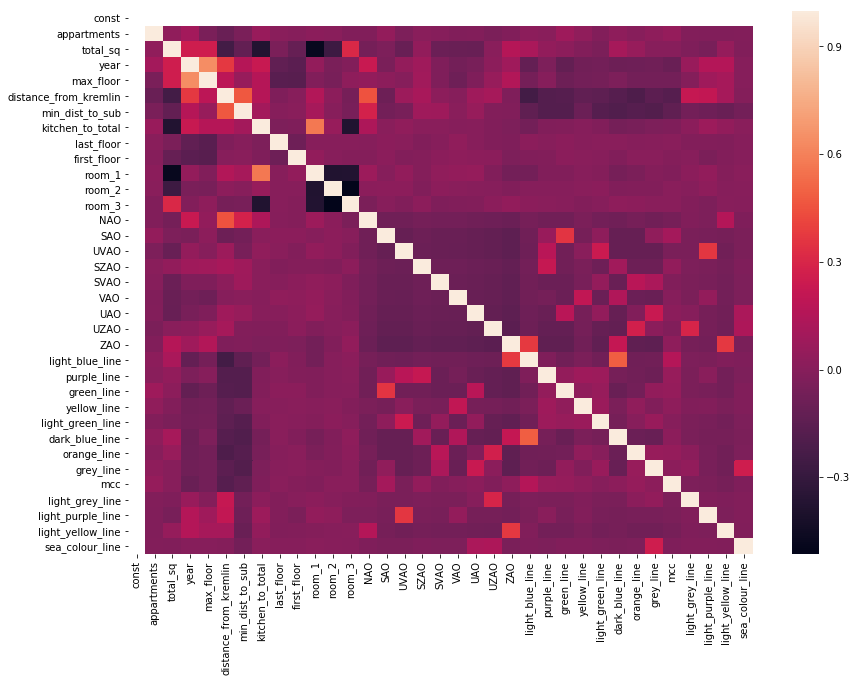

In [35]:
plt.figure(figsize=(14,10))
corr = X[model_3].drop(['CAO','room_4','subway_min','red_line'], axis=1).corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

# регрессия по районам 

## NAO

In [36]:
areas = ['NAO', 'SAO', 'UVAO', 'SZAO', 'SVAO', 'VAO', 'UAO','UZAO', 'ZAO','CAO']

In [37]:
area = areas[0]
print('Area:',area)
X = df[df[areas[0]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[0]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: NAO
Средняя цена: 15.979379190278177
Количество записей:  1798
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.802
Method:                 Least Squares   F-statistic:                     485.2
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 929.61
No. Observations:                1798   AIC:                            -1827.
Df Residuals:                    1782   BIC:                            -1739.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# SAO

In [38]:
area = areas[1]
print('Area:',area)
X = df[df[areas[1]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[1]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: SAO
Средняя цена: 16.42322409045717
Количество записей:  3838
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1707.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 1184.0
No. Observations:                3838   AIC:                            -2326.
Df Residuals:                    3817   BIC:                            -2195.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## UVAO

In [39]:
area = areas[2]
print('Area:',area)
X = df[df[areas[2]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[2]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: UVAO
Средняя цена: 16.059032893926087
Количество записей:  3953
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     1515.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 2631.0
No. Observations:                3953   AIC:                            -5218.
Df Residuals:                    3931   BIC:                            -5080.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# ZSAO

In [40]:
area = areas[3]
print('Area:',area)
X = df[df[areas[3]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[3]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: SZAO


/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


Средняя цена: 16.522901180886223
Количество записей:  2644
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     1380.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 682.83
No. Observations:                2644   AIC:                            -1330.
Df Residuals:                    2626   BIC:                            -1224.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

## SVAO

In [41]:
area = areas[4]
print('Area:',area)
X = df[df[areas[4]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[4]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: SVAO
Средняя цена: 16.194886171482157
Количество записей:  3188
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                     1490.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 1584.5
No. Observations:                3188   AIC:                            -3133.
Df Residuals:                    3170   BIC:                            -3024.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# VAO

In [42]:
area = areas[5]
print('Area:',area)
X = df[df[areas[5]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[5]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: VAO
Средняя цена: 16.144883026219237
Количество записей:  3299
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.920
Model:                            OLS   Adj. R-squared:                  0.920
Method:                 Least Squares   F-statistic:                     1989.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 1774.9
No. Observations:                3299   AIC:                            -3510.
Df Residuals:                    3279   BIC:                            -3388.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# UAO

In [43]:
area = areas[6]
print('Area:',area)
X = df[df[areas[6]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[6]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: UAO
Средняя цена: 16.167512602650394
Количество записей:  3884
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     1716.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:15   Log-Likelihood:                 1813.4
No. Observations:                3884   AIC:                            -3585.
Df Residuals:                    3863   BIC:                            -3453.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


## UZAO

In [44]:
area = areas[7]
print('Area:',area)
X = df[df[areas[7]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[7]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: UZAO
Средняя цена: 16.46942566553624
Количество записей:  4435
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.893
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1929.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:16   Log-Likelihood:                 1127.7
No. Observations:                4435   AIC:                            -2215.
Df Residuals:                    4415   BIC:                            -2088.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# ZAO

In [45]:
area = areas[8]
print('Area:',area)
X = df[df[areas[8]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[8]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: ZAO
Средняя цена: 16.769805498585693
Количество записей:  5711
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1884.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:16   Log-Likelihood:                -525.76
No. Observations:                5711   AIC:                             1090.
Df Residuals:                    5692   BIC:                             1216.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


# CAO

In [46]:
area = areas[9]
print('Area:',area)
X = df[df[areas[9]] == 1][model_3].drop(['room_4','subway_min','red_line'], axis=1)
Y = np.log(df[df[areas[9]] == 1]['price'])
print('Средняя цена:', Y.mean())
print('Количество записей: ', X.shape[0])
X.drop(areas,axis=1,inplace=True)
lr = sm.OLS(Y, X).fit()
print(lr.summary())

Area: CAO
Средняя цена: 17.323995941535326
Количество записей:  4466
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     1101.
Date:                Mon, 07 Oct 2019   Prob (F-statistic):               0.00
Time:                        12:25:16   Log-Likelihood:                -1183.5
No. Observations:                4466   AIC:                             2411.
Df Residuals:                    4444   BIC:                             2552.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------

/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:1100: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/anaconda3/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)
